In [185]:
import numpy as np
import cv2
import matplotlib as plt
from sklearn.cluster import KMeans

In [205]:
def mean_saliency(image):
    h, w, n_chan = image.shape
    w2 = min(h,w)
    scales = [w2/2, w2/4, w2/8]
    c_mat = np.zeros((h,w))
    for s in range(3):
        saliency = extract_saliency(image, scales[s])
        c_mat += saliency
    return c_mat

def get_limits(i, j, n_H, n_W, W_R):
    maxi_x = min(n_H, i + 1 + W_R//2)
    maxi_y = min(n_W, j + 1 + W_R//2)
    mini_x = max(0, i - W_R//2)
    mini_y = max(0, j - W_R//2)
    N = (maxi_x - mini_x)*(maxi_y - mini_y)
    return int(mini_x), int(mini_y), int(maxi_x), int(maxi_y), int(N)
    
def extract_saliency(img , scale):
    n_H, n_W, n_channel = img.shape
    W_R2 = scale
    N2 = W_R2**2
    print(W_R2)
    integral_img = cv2.integral(im)
    saliency_map = np.zeros((n_H,n_W))
    for i in range(n_H):
        for j in range(n_W):
            mini_x, mini_y, maxi_x, maxi_y, N = get_limits(i, j, n_H, n_W, W_R2)
            tmp = 1.0*(integral_img[mini_x,mini_y,:] + integral_img[maxi_x,maxi_y,:]\
                       - (integral_img[mini_x,maxi_y,:] \
                          + integral_img[maxi_x,mini_y,:]))/N
            saliency_map[i,j] = np.linalg.norm(img[i,j,:]-np.array(tmp))
    return saliency_map

    
class Bin:
    def __init__(self, pos, is_peak = False):
        self.pos = pos
        self.is_peak = is_peak

class Hill_climbing:
    def __init__(self, hist, n_bins):
        self.hist = hist
        self.n_bins = n_bins
        self.not_visited = []
        self.peaks_pos = []
        for i in range(n_bins):
            for j in range(n_bins):
                for k in range(n_bins):
                    if hist[i,j,k] != 0:
                        self.not_visited.append((i,j,k))
                        
    def cyclic_coord(self, x):
        if x == 0:
            min_x = self.n_bins - 1
            max_x = 1
        elif x == self.n_bins - 1:
            min_x = self.n_bins - 2
            max_x = 0
        else:
            min_x = x - 1
            max_x = x + 1
        return min_x, max_x 

    def find_neighbors(self, pos):
        x,y,z = pos
        n_bins = self.hist.shape[0]
        min_x, max_x = self.cyclic_coord(x)
        min_y, max_y = self.cyclic_coord(y)
        min_z, max_z = self.cyclic_coord(z)
        neighbors_coord = np.array([[min_x, x, max_x], [min_y, y, max_y], [min_z, z, max_z]])
        neighbors = np.zeros((3,3,3))
        for i, val_x in enumerate(neighbors_coord[0]):
            for j, val_y in enumerate(neighbors_coord[1]):
                for k, val_z in enumerate(neighbors_coord[2]):
                    neighbors[i,j,k] = self.hist[val_x, val_y, val_z]
        return neighbors_coord, neighbors
    
    def find_peaks(self):

        curr_bin = Bin(self.not_visited[0])
        self.not_visited.remove(self.not_visited[0])
        print('not visited',len(self.not_visited))

        while len(self.not_visited) != 0:
            while curr_bin.is_peak == False:
                curr_bin = self.uphill_move(curr_bin)
            if curr_bin.pos not in self.peaks_pos:
                self.peaks_pos.append(curr_bin.pos)

            new_ind = np.random.randint(0,len(self.not_visited),1)[0]
            hist_ind = self.not_visited[new_ind]
            self.not_visited.remove(hist_ind)
            curr_bin.pos = hist_ind
            curr_bin.is_peak = False
        print('end')
        for l in range(len(self.peaks_pos)): 
            print(self.peaks_pos[l])
        return len(self.peaks_pos)
    
    def uphill_move(self,curr_bin):
        x, y, z = curr_bin.pos
        neigh_coord, neighbors = self.find_neighbors(curr_bin.pos)
        true_neigh = np.delete(neighbors,13)
        
        if (self.hist[x,y,z] >= true_neigh).all() and (self.hist[x,y,z] > true_neigh).any():
            #print('val', hist[x,y,z])
            #print('best')
            curr_bin.is_peak = True
            
        elif (hist[x,y,z] == neighbors).all():
            #print('val', hist[x,y,z])
            #print('draw')
            curr_bin = self.resolve_draw(curr_bin, neigh_coord)
            
        else:
            #print('weak')
            #print('val', hist[x,y,z])
            loc_x, loc_y, loc_z = np.unravel_index(np.argmax(neighbors, axis=None), neighbors.shape)
            curr_bin.pos = neigh_coord[0,loc_x], neigh_coord[1,loc_y], neigh_coord[2,loc_z]
            if curr_bin.pos in self.not_visited:
                self.not_visited.remove(curr_bin.pos)
        return curr_bin
    

    def resolve_draw(self, curr_bin, neigh_coord):
        for i in neigh_coord[0]:
            for j in neigh_coord[1]:
                for k in neigh_coord[2]:
                    if (i,j,k) in self.not_visited:
                        curr_bin.pos = (i,j,k)
                        self.not_visited.remove(curr_bin.pos)
                        return curr_bin
        curr_bin.is_peak = True
        return curr_bin

def apply_kmeans(image, K):
    n_H, n_W, n_C = image.shape
    reshaped_image = np.reshape(image,(n_H*n_W, n_C))
    kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10).fit(reshaped_image)
    y_pred = kmeans.predict(reshaped_image)
    return np.reshape(y_pred, (n_H,n_W))

def saliency_means_per_region(image, K):
    M = mean_saliency(image)
    n_H, n_W = M.shape
    region_idxes = apply_kmeans(image, K)
    V = np.zeros((K,))
    for k in range(K):
        N = 0
        for i in range(n_H):
            for j in range(n_W):
                if region_idxes[i,j] == k:
                    V[k] += M[i,j]
                    N += 1
        V[k] = (1.0*V[k])/N
    return V, region_idxes

def segmented_image(image, V , threshold, region_idxes):
    n_H, n_W, n_C = image.shape
    test_array = V > threshold
    print('test_arr',test_array)
    #segmented_object_class = np.argmax(test_array)
    chosen_classes = [i for i, x in enumerate(test_array) if x]
    print('classes', chosen_classes)
    segmented_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(n_H):
        for j in range(n_W):
            #if region_idxes[i,j] == segmented_object_class:
            if region_idxes[i,j] in chosen_classes:
                segmented_image[i,j,:] = image[i,j,:]
    return segmented_image

(428, 641, 3)


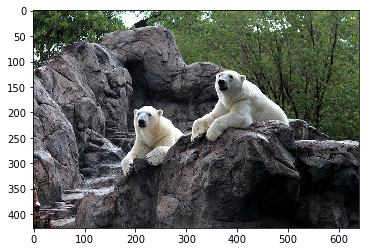

In [223]:
image = cv2.imread("img/COCO_COCO_train2014_000000001737.jpg")
im = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
%matplotlib inline
plt.pyplot.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
i_im = cv2.integral(im)
print(i_im.shape)

In [224]:
n_bins = 16
hist = cv2.calcHist([im],[0,1,2],None,[n_bins,n_bins,n_bins],[0,100,-128,127,-128,127])
#hist = cv2.calcHist([im],[0,1,2],None,[n_bins,n_bins,n_bins],[0,255,0,255,0,255])
#print(hist)
hill_climb = Hill_climbing(hist, n_bins)
k = hill_climb.find_peaks()

not visited 26
end
(1, 15, 15)
(7, 15, 15)
(12, 15, 15)
(3, 15, 15)


In [225]:
V, region_idxes = saliency_means_per_region(im, k)
print(V)


213.5
106.75
53.375
[  85.61843823  108.2656431   296.4101758    61.16015359]


test_arr [False  True  True False]
classes [1, 2]


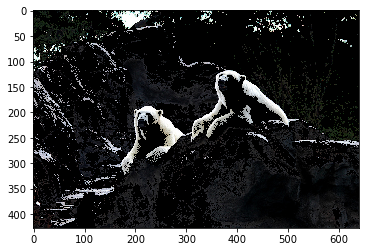

In [226]:
threshold = np.median(V)
#threshold = 
seg_image = segmented_image(image, V, threshold , region_idxes)
seg_image = cv2.cvtColor(seg_image, cv2.COLOR_RGB2BGR)
plt.pyplot.imshow(seg_image)